# Acoustic Processing
Acoustic signals contain a lot of information. A great example of an acoustic signal is speech which is our primary form of communication. The speech signal contains information on the message to be conveyed, the speaker, their emotional state among other things.

Despite the fact that speech applications are probably the most common examples of acoustic processing. Other examples include:
1. Fault diagnosis in machinery
1. Noise pollution monitoring 


## The Acoustic Signal
An acoustic signal consists of variation of air pressure. This pressure variation is picked up by a microphone and transformed into a voltage signal which is then sampled at an appropriate rate to produce a digital signal.

We will work exclusively with digital signals which are a sequence of sample values. We will make use of the [`librosa`](https://librosa.org/doc/latest/index.html) package extensively in this tutorial. 



In [1]:
# all imports for the tutorail
import os
import librosa
import random

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import IPython.display


### Audio Examples
As an example let us visualise and listen to a few examples. Select some audio below and listen to it and visualise it.


In [2]:
samples_dir = 'audio-samples/'

audio_files = os.listdir(samples_dir)

w = widgets.Dropdown(
    options=audio_files,
    value=audio_files[0],
    description='Audio files:',
    disabled=False,
)

display(w)

Dropdown(description='Audio files:', options=('piano-C6.wav',), value='piano-C6.wav')

In [3]:
signal, sampling_rate = librosa.load(os.path.join(samples_dir, w.value), 
                                     sr=None)

`signal` contains the audio samples while `sampling_rate` is the sampling rate used to obtain the audio. 

In [4]:
# listen to the audio
IPython.display.Audio(data=signal, rate=sampling_rate)

Text(0.5, 0, 'Time(s)')

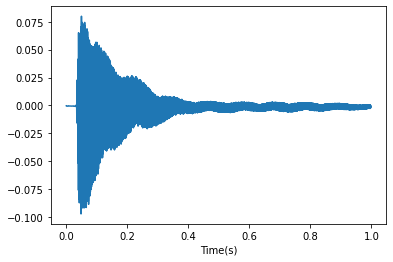

In [5]:
# visualise the audio samples
%matplotlib inline
plt.plot(np.arange(len(signal)) / sampling_rate, signal)
plt.xlabel(r'Time(s)')


In [6]:
# check the sampling rate
sampling_rate

11025

### Zooming in
The audio is sampled at a rate $f_s$. This means that the samples are collected every $T_s=\frac{1}{f_s}$ seconds. Often in audio processing we work with short time segments in the millisecond range. Lets zoom into a 10ms segment.

Text(0.5, 0, 'Time(s)')

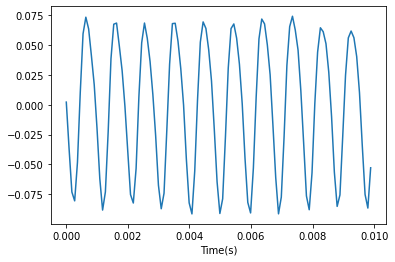

In [7]:
segment_length_seconds = 10e-3
segment_length_samples = int(sampling_rate * segment_length_seconds)

segment_start = random.choice(range(0, len(signal) - segment_length_samples))

plt.plot(np.arange(segment_length_samples) / sampling_rate, 
         signal[segment_start : segment_start + segment_length_samples])
plt.xlabel(r'Time(s)')

Run the code above a few times. You will notice that the signal changes from one segment to the other but is essentially the same over a segment. If this doesn't hold true for the signal you chose, select the piano file and repeat the above.

For mose audio processing applications, we work with short segments of audio in our analysis.